In [1]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append('./../../')
sys.path.append('./../../designer/script/')


from tmm.get_E import get_E_free
from tmm.get_jacobi_arb_adjoint import get_jacobi_E_free_form
from tmm.get_jacobi_adjoint import get_jacobi_adjoint
from tmm.get_spectrum import get_spectrum_free
from film import FreeFormFilm, TwoMaterialFilm
from tmm.autograd_wrapper import *
from tmm.E_to_spectrum import *

from optimizer.adam import AdamThicknessOptimizerAutograd

import matplotlib.pyplot as plt
import numpy as np
import copy
import torch

In [11]:
# set exp 
from spectrum import Spectrum


wls = np.linspace(400, 700, 500)

inc_ang=45.
layer_number=200

layer_thickness=10

steps=200
stepsize=1



np.random.seed(0)
film = TwoMaterialFilm('TiO2', 'SiO2', 'Si', np.random.random(layer_number) * layer_thickness)
# n_layers, n_sub, n_inc = film.calculate_n_array(wls), film.calculate_n_sub(wls), film.calculate_n_inc(wls)
film.add_spec_param(inc_ang, wls)
init_film = copy.deepcopy(film)


psi_target = torch.tensor(1).cuda().arctan().repeat(wls.shape[0])
print(psi_target[0])
spec = Spectrum(inc_ang, wls, np.zeros_like(psi_target.detach().cpu()))

grad = torch.empty(film.get_layer_number())
loss_fn = lambda E: (E_to_Psi(E) - psi_target).square().sum()

def eval_loss(film):
    film.get_spec().calculate_E()
    E_tensor = torch.tensor(copy.deepcopy(film.get_spec().spec_E), device='cuda')
    if not (E_tensor == E_tensor).all():
        print(E_tensor == E_tensor)
    return loss_fn(E_tensor)

adam = AdamThicknessOptimizerAutograd(
    film, 
    target_spec_ls=film.get_all_spec_list(), # used for determining wls etc.
    loss_fn=loss_fn, 
    eval_loss=eval_loss, 
    max_steps=steps, 
    alpha=stepsize, 
    show=lambda i: i % 10 == 0
)
adam.optimize()




tensor(0.7854, device='cuda:0')
tensor([[-0.8573-3.1792j,  1.3186+1.1084j],
        [-1.2603-3.1525j,  1.6097+1.0415j],
        [-1.6563-3.1027j,  1.8966+0.9729j],
        ...,
        [ 0.9875-2.1279j,  0.4812+0.1725j],
        [ 0.9460-2.1419j,  0.4597+0.1745j],
        [ 0.9044-2.1553j,  0.4381+0.1765j]], device='cuda:0',
       dtype=torch.complex128)
tensor([0.8921, 0.8667, 0.8418, 0.8190, 0.7990, 0.7817, 0.7667, 0.7537, 0.7421,
        0.7316, 0.7219, 0.7125, 0.7032, 0.6939, 0.6842, 0.6739, 0.6628, 0.6508,
        0.6375, 0.6228, 0.6062, 0.5876, 0.5666, 0.5428, 0.5158, 0.4854, 0.4510,
        0.4125, 0.3694, 0.3217, 0.2691, 0.2117, 0.1496, 0.0828, 0.0120, 0.0648,
        0.1461, 0.2337, 0.3289, 0.4330, 0.5470, 0.6692, 0.7926, 0.9030, 0.9804,
        1.0107, 0.9986, 0.9615, 0.9159, 0.8709, 0.8302, 0.7947, 0.7641, 0.7376,
        0.7143, 0.6937, 0.6749, 0.6576, 0.6411, 0.6252, 0.6096, 0.5938, 0.5779,
        0.5614, 0.5445, 0.5268, 0.5085, 0.4896, 0.4703, 0.4509, 0.4320, 0.4145,
  

KeyboardInterrupt: 

In [7]:
np.arctan(0 + 0j)

0j

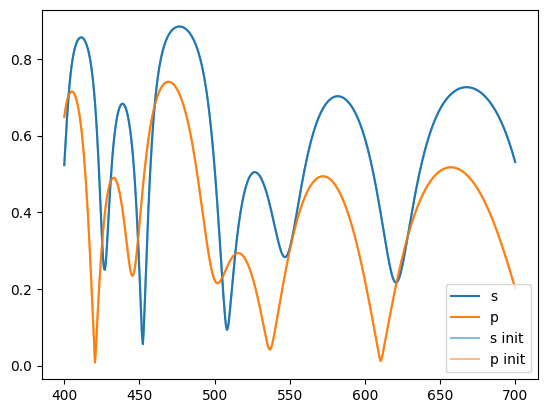

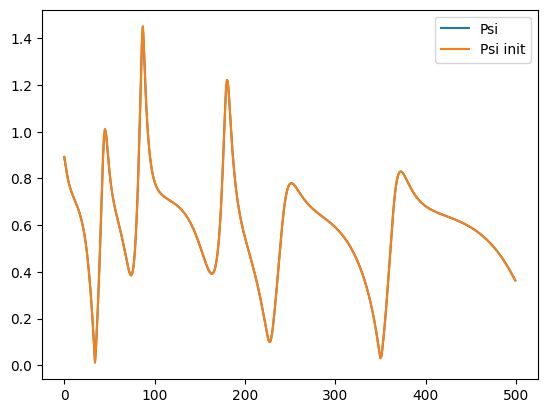

In [58]:
film = adam.records[-1][0]
film.get_spec().calculate_E()
Rs = torch.tensor(film.get_spec().get_r()[:, 0]).abs() # rs
Rp = torch.tensor(film.get_spec().get_r()[:, 1]).abs() # rp

Rs_init = torch.tensor(init_film.get_spec().get_r()[:, 0]).abs() # rs
Rp_init = torch.tensor(init_film.get_spec().get_r()[:, 1]).abs() # rp

fig, ax = plt.subplots(1, 1)
ax.plot(wls, Rs, label='s')
ax.plot(wls, Rp, label='p')
ax.plot(wls, Rs_init, label='s init', c='C0', alpha=0.5)
ax.plot(wls, Rp_init, label='p init', c='C1', alpha=0.5)
ax.legend()

fig, ax = plt.subplots(1, 1)

ax.plot(E_to_Psi(film.get_spec().spec_E), label='Psi')
ax.plot(E_to_Psi(init_film.get_spec().spec_E), label='Psi init')
ax.legend()